In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.utils.validation import check_is_fitted
from ipywidgets import interact, interactive
from preprocessing import MultilabelFeatureSelector, TagGrouper
from plotting import plot_confusion_matrix, plot_scores, plot_precision_recall, plot_roc, plot_information_gain, plot_multilabel_precision_recall, plot_multilabel_roc, plot_precision_recall
from persistence import load_all_classifiers

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
class PrefitVotingClassifier(object):
    """Stripped-down version of VotingClassifier that uses prefit estimators"""
    def __init__(self, estimators, voting='hard', weights=None):
        self.estimators = [e[1] for e in estimators]
        self.named_estimators = dict(estimators)
        self.voting = voting
        self.weights = weights

    def fit(self, X, y, sample_weight=None):
        raise NotImplementedError
        
    def predict(self, X):
        """ Predict class labels for X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        maj : array-like, shape = [n_samples]
            Predicted class labels.
        """

        check_is_fitted(self, 'estimators')
        if self.voting == 'soft':
            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)
            maj = np.apply_along_axis(lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions.astype('int'))
        return maj

    def _collect_probas(self, X):
        """Collect results from clf.predict calls. """
        return np.asarray([clf.predict_proba(X) for clf in self.estimators])

    def _predict_proba(self, X):
        """Predict class probabilities for X in 'soft' voting """
        if self.voting == 'hard':
            raise AttributeError("predict_proba is not available when"
                                 " voting=%r" % self.voting)
        check_is_fitted(self, 'estimators')
        avg = np.average(self._collect_probas(X), axis=0, weights=self.weights)
        return avg

    @property
    def predict_proba(self):
        """Compute probabilities of possible outcomes for samples in X.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        return self._predict_proba

    def transform(self, X):
        """Return class labels or probabilities for X for each estimator.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        Returns
        -------
        If `voting='soft'`:
          array-like = [n_classifiers, n_samples, n_classes]
            Class probabilities calculated by each classifier.
        If `voting='hard'`:
          array-like = [n_samples, n_classifiers]
            Class labels predicted by each classifier.
        """
        check_is_fitted(self, 'estimators')
        if self.voting == 'soft':
            return self._collect_probas(X)
        else:
            return self._predict(X)

    def _predict(self, X):
        """Collect results from clf.predict calls. """
        return np.asarray([clf.predict(X) for clf in self.estimators]).T

In [3]:
# Load classifiers
classifiers = load_all_classifiers('models-all-0c25f9f')

Loading model tag_1
Loading model tag_11
Loading model tag_12
Loading model tag_2
Loading model tag_3
Loading model tag_5
Loading model tag_6
Loading model tag_9


In [4]:
tags = [1, 2, 3, 5, 6, 9, 11, 12]
tag_names = ['Blanking', 'Nonsense', 'QualityIssue', 'FalseFact', 'Syntax', 'EditWar', 'Intention', 'Constructive']

---
## Import Dataset

In [5]:
df = pd.read_csv('./data/features-0c25f9f.csv', index_col='revision_id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,34.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,1.0,25.0,25.0,...,0.0,1.0,0.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.0,7837.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.0,2108.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,0.0,4077.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


---
## Preprocessing

In [6]:
def preprocessing(frame, features):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('feature_selector', MultilabelFeatureSelector(feature_columns)),
        ('tag_grouper', TagGrouper())
    ])

    return preprocess_pipeline.transform(frame)\
        .fillna(0)

In [7]:
processed_df = preprocessing(df, 'all')

In [8]:
processed_df

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,all_tags
revision_id,,,,,,,,,,,,,,,,,,,,,
2148821,0.0,0.0,16.0,-1.0,1.0,-1.0,1.0,0.0,2454.0,253316.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0,[12]
2359434,0.0,0.0,0.0,-1.0,3.0,-1.0,0.0,1.0,6.0,6.0,...,0.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]
2880168,0.0,0.0,3.0,-1.0,1.0,-1.0,0.0,0.0,14278.0,-1.0,...,5.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]
2970351,0.0,0.0,22.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]
2975763,1.0,0.0,0.0,18.0,2.0,1.0,0.0,0.0,4228.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,"[2, 11, 1]"
3179674,0.0,0.0,1.0,-1.0,3.0,-1.0,0.0,1.0,8282.0,8282.0,...,0.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]
3200065,0.0,0.0,0.0,-1.0,4.0,-1.0,0.0,1.0,1248.0,1248.0,...,42.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,-0.200000,0.0,[12]
3412132,0.0,0.0,19.0,-1.0,6.0,-1.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]
3511384,0.0,0.0,15.0,-1.0,7.0,-1.0,0.0,0.0,18417.0,-1.0,...,82.0,0.0,0.0,0.0,-1.000000,0.000000,0.00000,0.000000,0.0,[12]


In [9]:
# X, y split
X = processed_df.drop(['all_tags'], axis=1)
y = MultiLabelBinarizer().fit_transform(processed_df['all_tags'])

In [10]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 121)
y train (3720, 8)
X test (1240, 121)
y test (1240, 8)


In [11]:
y_test_vandalism = 1 - y_test[:, 7]
y_test_binary = pd.concat([pd.Series(y_test[:, 7]), pd.Series(y_test_vandalism)], axis=1)

In [12]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
estimators = sorted(estimators, key=lambda e: int(e[0]))
fitted_clfs = []

# Train classifiers and make predicitions per tag
for i, e in enumerate(estimators):
    print('Train clf for tag', e[0], 'at index', i)
    clf = e[1]
    # Retrain classifier on tag data
    y_train_tag = y_train[:, i]
    clf.fit(X_train, y_train_tag)
    
    # Predict tag for test
    fitted_clfs.append((e[0], clf))

Train clf for tag 1 at index 0
Train clf for tag 2 at index 1
Train clf for tag 3 at index 2
Train clf for tag 5 at index 3
Train clf for tag 6 at index 4
Train clf for tag 9 at index 5
Train clf for tag 11 at index 6
Train clf for tag 12 at index 7


In [13]:
# Construct model hierarchie
vandalism_clfs = fitted_clfs[:7]
constructive_clf = fitted_clfs[7][1]
vandalism_clf = PrefitVotingClassifier(vandalism_clfs, voting='soft', weights=[1, 1, 1, 1, 1, 1, 1])

In [14]:
# Make predicitions
y_test_vandalism_prob = vandalism_clf.predict_proba(X_test)
y_test_constructive_prob = constructive_clf.predict_proba(X_test)

In [15]:
# Combine predictions
vandalism = y_test_vandalism_prob[:, 1]
constructive = y_test_constructive_prob[:, 1]

y_test_vandalism_prob = vandalism / (vandalism + constructive)
y_test_constructive_prob = constructive / (vandalism + constructive)

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


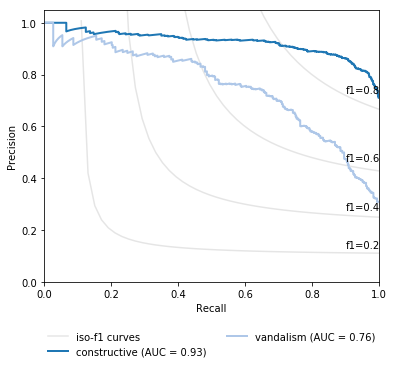

In [16]:
# Encode constructive vs vandalism as seperate values y_true
y_test_predict = pd.concat([pd.Series(y_test_constructive_prob), pd.Series(y_test_vandalism_prob)], axis=1)

plot_multilabel_precision_recall(y_test_binary.as_matrix(),
                                 y_test_predict.as_matrix(),
                                  tags,
                                 ['constructive', 'vandalism'],
                                 'figures/binary/binary_precision_recall.pdf')

In [18]:
# y_test_predict.to_csv('temp/single_label_prediction.csv')

In [19]:
# y_test_binary.to_csv('temp/single_label_true', index=False)

In [23]:
import os
from sklearn.externals import joblib

MODEL_DIR = 'trained-models/all-features'

# Save trained model to disk
def save_model(tag_id, clf):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    
    # Pickle dump classifier to disk
    model_path = os.path.join(MODEL_DIR, 'tag_%s.pkl' % tag_id)
    joblib.dump(clf, model_path)
    print('Save classifier for tag', tag_id)

for estimator in estimators:
    save_model(estimator[0], estimator[1])

Save classifier for tag 1
Save classifier for tag 2
Save classifier for tag 3
Save classifier for tag 5
Save classifier for tag 6
Save classifier for tag 9
Save classifier for tag 11
Save classifier for tag 12
